In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from rdkit.Chem import (
                        PandasTools,
                        Descriptors
                        )

from rdkit.Chem.Draw import IPythonConsole

# ML for thermochemical data prediction

We can use the data you worked with for the EDA workshop to demonstrate how fit a simple ML model to predict the boiling point of organic compounds from a small set of descriptors.

This is an example of

**Supervised learning** as applied to a **regression** task.

</br>

Supervised learning
: The model learns from data for which a label (known value or category) is associated with each input (set of feature values)

Regression task
: Model predicts a continuous numerical value based on the input features


In [36]:
bp_df = pd.read_csv("data/alcohol_acid_phys_data_cleaned.csv")
bp_df

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,mp / dC,bp / dC,density / g/ml,SMILES
0,1-alkanol,Methanol,1,4,1,32.04,-98.0,65,0.7910,CO
1,1-alkanol,Ethanol,2,6,1,46.07,-114.0,78,0.7890,CCO
2,1-alkanol,1-Propanol,3,8,1,60.09,-124.0,97,0.8040,CCCO
3,1-alkanol,1-Butanol,4,10,1,74.12,-89.0,118,0.8100,CCCCO
4,1-alkanol,1-Pentanol,5,12,1,88.15,-78.0,138,0.8140,CCCCCO
...,...,...,...,...,...,...,...,...,...,...
73,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,-33.0,200,0.9230,CC(C)CCC(O)=O
74,Benzoic acids,Benzoic acid,7,6,2,122.12,122.0,249,1.2660,OC(=O)c1ccccc1
75,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,107.0,258,1.0620,Cc1ccccc1C(O)=O
76,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,77.0,266,1.2286,OC(=O)Cc1ccccc1


The data is read in from a csv file of the data cleaned in the [EDA workshop](../workshop_files/eda_workshop), so should be prepared, but we can quickly check.

In [37]:
# Check for missing values
bp_df.isna().sum()

Class              0
IUPAC name         0
#C                 0
#H                 0
#O                 0
Molweight g/mol    0
mp / dC            0
bp / dC            0
density / g/ml     0
SMILES             0
dtype: int64

In [38]:
# Check data types
bp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Class            78 non-null     object 
 1   IUPAC name       78 non-null     object 
 2   #C               78 non-null     int64  
 3   #H               78 non-null     int64  
 4   #O               78 non-null     int64  
 5   Molweight g/mol  78 non-null     float64
 6   mp / dC          78 non-null     float64
 7   bp / dC          78 non-null     int64  
 8   density / g/ml   78 non-null     float64
 9   SMILES           78 non-null     object 
dtypes: float64(3), int64(4), object(3)
memory usage: 6.2+ KB


The numerical types are as expected. The category type for the `class` column has not been automatically recognised, understandably. For now we will not be working with that column, so will leave as is.

We will start by dropping any rows without a SMILES string and also the melting point column as we are going to try to predict the boiling point.

In [39]:
# Drop rows with missing SMILES string
bp_df = bp_df[bp_df["SMILES"] != "not found"].reset_index(drop=True)

bp_df = bp_df.drop(columns=["mp / dC"])
bp_df

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,bp / dC,density / g/ml,SMILES
0,1-alkanol,Methanol,1,4,1,32.04,65,0.7910,CO
1,1-alkanol,Ethanol,2,6,1,46.07,78,0.7890,CCO
2,1-alkanol,1-Propanol,3,8,1,60.09,97,0.8040,CCCO
3,1-alkanol,1-Butanol,4,10,1,74.12,118,0.8100,CCCCO
4,1-alkanol,1-Pentanol,5,12,1,88.15,138,0.8140,CCCCCO
...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,200,0.9230,CC(C)CCC(O)=O
73,Benzoic acids,Benzoic acid,7,6,2,122.12,249,1.2660,OC(=O)c1ccccc1
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,258,1.0620,Cc1ccccc1C(O)=O
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,266,1.2286,OC(=O)Cc1ccccc1


,Class,IUPAC name,#C,#H,#O,Molweight g/mol,bp / dC,density / g/ml,SMILES,ROMol
0,1-alkanol,Methanol,1,4,1,32.04,65,0.7910,CO,
1,1-alkanol,Ethanol,2,6,1,46.07,78,0.7890,CCO,
2,1-alkanol,1-Propanol,3,8,1,60.09,97,0.8040,CCCO,
3,1-alkanol,1-Butanol,4,10,1,74.12,118,0.8100,CCCCO,
4,1-alkanol,1-Pentanol,5,12,1,88.15,138,0.8140,CCCCCO,
...,...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,200,0.9230,CC(C)CCC(O)=O,
73,Benzoic acids,Benzoic acid,7,6,2,122.12,249,1.2660,OC(=O)c1ccccc1,
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,258,1.0620,Cc1ccccc1C(O)=O,
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,266,1.2286,OC(=O)Cc1ccccc1,

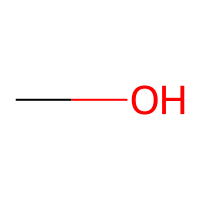
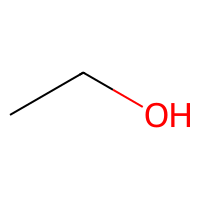
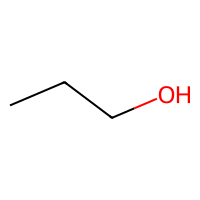
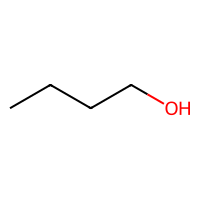
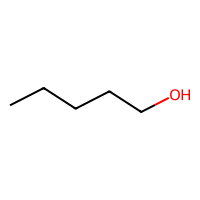
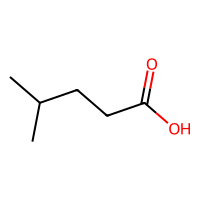
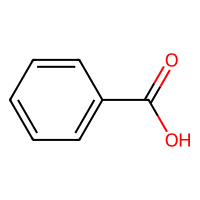
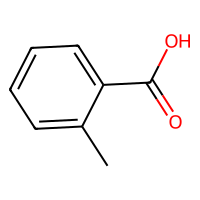
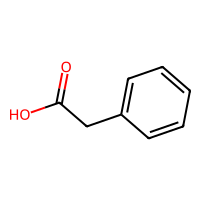
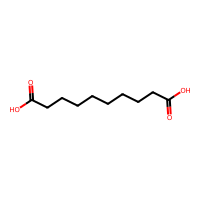

In [40]:
# Add RDKit molecules to the dataframe
PandasTools.AddMoleculeColumnToFrame(bp_df, smilesCol="SMILES")
bp_df

In [41]:
# Adapted from https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html

def getMolDescriptors(mol, descriptor_list=None, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    if not(descriptor_list):
        descriptors = Descriptors._descList
    # TODO: Add else clause to handle a list numbers corresponding to the descriptor indices
    else:
        descriptors = [Descriptors._descList[idx] for idx in descriptor_list]

    for nm,fn in descriptors:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [42]:
# These are the descriptors selected to calculate for the molecules.
# 118 NumHAcceptors
# 119 NumHDonors
# 27 BalabanJ - a topological descriptor expressing molecular connectivity and branching
# 28 BertzCT - a topological complexity index
# 83 TPSA - total polar surface area

descriptor_list = [118, 119, 27, 28, 83]


calc_descriptors = [getMolDescriptors(mol, descriptor_list=descriptor_list) for mol in bp_df["ROMol"]]

# Create a dataframe from the calculated descriptors
descriptor_df = pd.DataFrame(calc_descriptors)

# Add the descriptors to the dataframe as new columns
bp_df = pd.concat([bp_df, descriptor_df], axis=1)
bp_df

,Class,IUPAC name,#C,#H,#O,Molweight g/mol,bp / dC,density / g/ml,SMILES,ROMol,NumHAcceptors,NumHDonors,BalabanJ,BertzCT,TPSA
0,1-alkanol,Methanol,1,4,1,32.04,65,0.7910,CO,<rdkit.Chem.rdchem.Mol object at 0x31e02bca0>,1,1,1.000000,2.000000,20.23
1,1-alkanol,Ethanol,2,6,1,46.07,78,0.7890,CCO,<rdkit.Chem.rdchem.Mol object at 0x323eb2730>,1,1,1.632993,2.754888,20.23
2,1-alkanol,1-Propanol,3,8,1,60.09,97,0.8040,CCCO,<rdkit.Chem.rdchem.Mol object at 0x323eb1310>,1,1,1.974745,5.245112,20.23
3,1-alkanol,1-Butanol,4,10,1,74.12,118,0.8100,CCCCO,<rdkit.Chem.rdchem.Mol object at 0x323eb20a0>,1,1,2.190610,11.119415,20.23
4,1-alkanol,1-Pentanol,5,12,1,88.15,138,0.8140,CCCCCO,<rdkit.Chem.rdchem.Mol object at 0x323eb2ce0>,1,1,2.339092,15.900135,20.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Branched alkanoic acid,4-Methylpentanoic acid,6,12,2,116.16,200,0.9230,CC(C)CCC(O)=O,<rdkit.Chem.rdchem.Mol object at 0x323eb1230>,1,1,3.050078,76.597721,37.30
73,Benzoic acids,Benzoic acid,7,6,2,122.12,249,1.2660,OC(=O)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x323eb3ae0>,1,1,2.981455,203.415953,37.30
74,Benzoic acids,2-Methyl-benzoic acid,8,8,2,136.14,258,1.0620,Cc1ccccc1C(O)=O,<rdkit.Chem.rdchem.Mol object at 0x323eb3a70>,1,1,3.152941,253.189433,37.30
75,Phenyl- alkanoic acid,Phenylethanoic acid,8,8,2,136.14,266,1.2286,OC(=O)Cc1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x323eb3840>,1,1,2.674242,215.959017,37.30


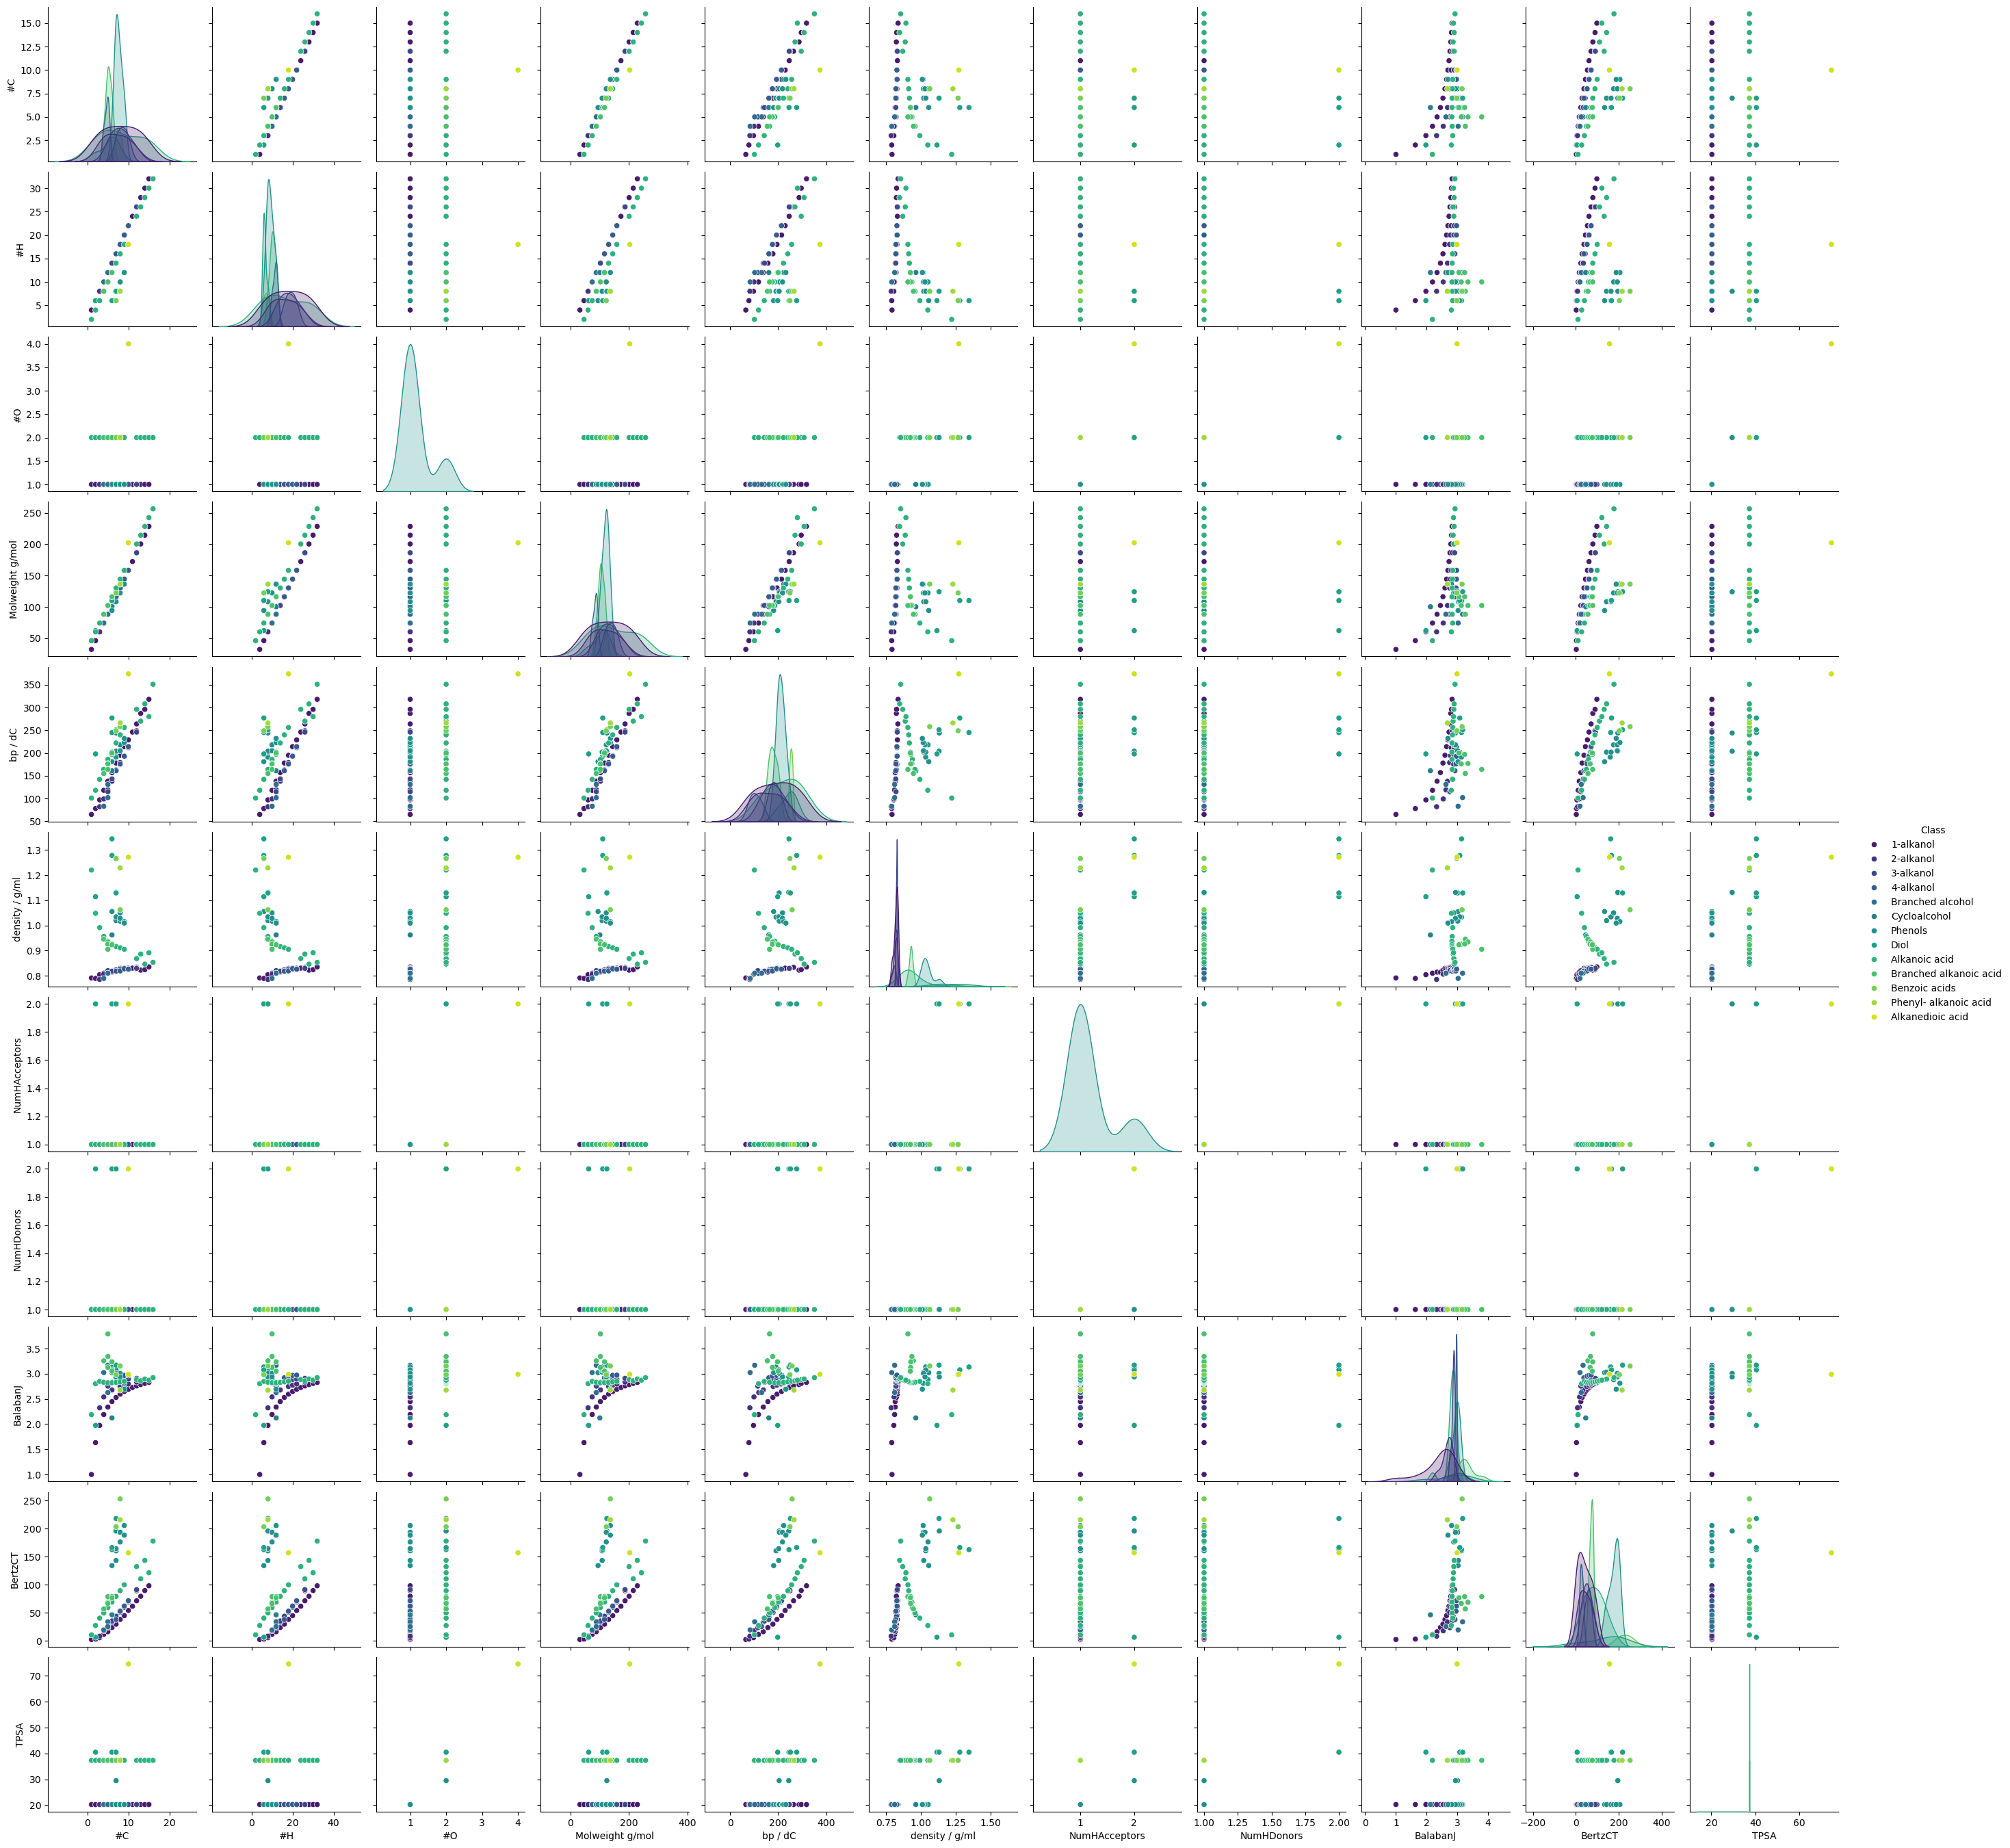

In [43]:
# To remind us of the relationship between the variables, we can plot a pairplot and heatmap
# Pairplot
sns.pairplot(bp_df, hue="Class", diag_kind="kde",  palette="viridis")
plt.show()

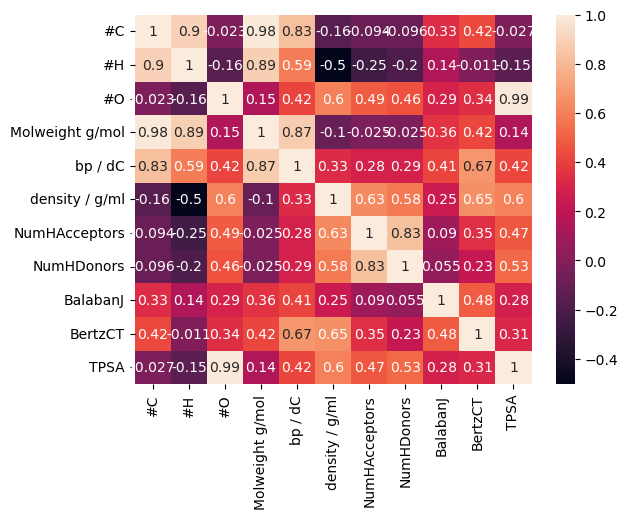

In [44]:
corr = bp_df.drop(columns=["Class", "IUPAC name", "SMILES", "ROMol"]).corr()

sns.heatmap(corr, annot=True)
plt.show()

In [45]:
# corr_abs = bp_df.drop(columns=["Class", "IUPAC name", "SMILES", "ROMol"]).corr().abs()
# upper = corr_abs.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# upper

This is all looking rather busy - it would be better to look at subsets of the features.

What we can see is:

- The feature most strongly correlated with the target variable is the molecular weight.
- Molecular weight is very strongly correlated with number of carbons and hydrogens
- Most of the other features are only moderately or weakly correlated to the target variable.



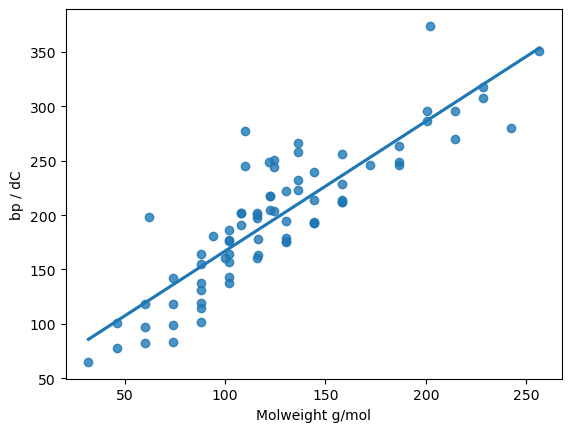

In [46]:
# A closer look at the correlation between the boiling point and the molecular weight
sns.regplot(data=bp_df, x="Molweight g/mol", y="bp / dC",  fit_reg=True,  ci=None)
plt.show()

For the moment, we will drop the `#C` and `#H` columns. We will see that analysing the initial model can help tell us about the importance of the features. 

We will also drop the non-numerical features for this task.

In [47]:
cols_drop = ["#C", "#H", "IUPAC name", "SMILES", "ROMol", "Class"]

prep_df = bp_df.drop(columns=cols_drop)
prep_df

,#O,Molweight g/mol,bp / dC,density / g/ml,NumHAcceptors,NumHDonors,BalabanJ,BertzCT,TPSA
0,1,32.04,65,0.7910,1,1,1.000000,2.000000,20.23
1,1,46.07,78,0.7890,1,1,1.632993,2.754888,20.23
2,1,60.09,97,0.8040,1,1,1.974745,5.245112,20.23
3,1,74.12,118,0.8100,1,1,2.190610,11.119415,20.23
4,1,88.15,138,0.8140,1,1,2.339092,15.900135,20.23
...,...,...,...,...,...,...,...,...,...
72,2,116.16,200,0.9230,1,1,3.050078,76.597721,37.30
73,2,122.12,249,1.2660,1,1,2.981455,203.415953,37.30
74,2,136.14,258,1.0620,1,1,3.152941,253.189433,37.30
75,2,136.14,266,1.2286,1,1,2.674242,215.959017,37.30


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [49]:
# By convention, the target variable is denoted by y and the features are denoted by X

y_full = prep_df["bp / dC"]
X_full = prep_df.drop(columns=["bp / dC"])

In [50]:
# train_test_split shuffles the data by default and splits it into training and testing sets. The 
# proportion of the data that is used for testing is determined by the test_size parameter. Here, 
# we are using 80 % of the data for training and 20% for the test set. 
# The random_state parameter is used to set the seed for the random number generator so that the 
# results are reproducible.

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

In [51]:
# Check the size of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61, 8), (16, 8), (61,), (16,))

[`Scikit-learn`](https://scikit-learn.org/stable/index.html) makes many models available via a consistent interface.

We are going to use a linear regression model for this task.

In [52]:
from sklearn import linear_model

In [53]:
# Create a linear regression model
reg = linear_model.LinearRegression()

# Fit the model to the training data
reg.fit(X_train, y_train)

LinearRegression()

In [54]:
# Predict the boiling points of the test set
y_pred = reg.predict(X_test)


We can plot the boiling points that the model predicted for the test set against the known true values to see how good a job the model makes of the predictions

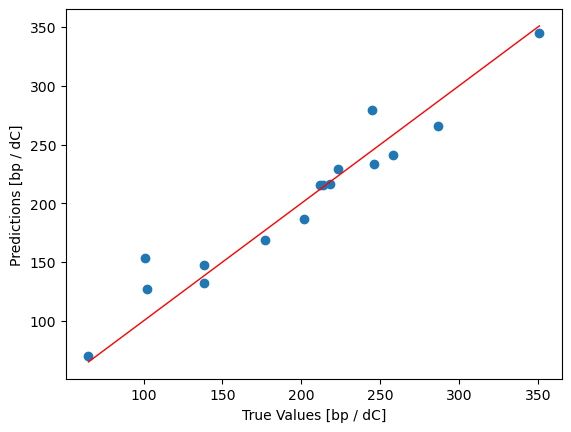

In [55]:

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', lw=1, color="red")
plt.xlabel("True Values [bp / dC]")
plt.ylabel("Predictions [bp / dC]")
plt.show()

In [56]:
# The r^2 value is a measure of how well the model fits the data. It ranges from 0 to 1, 
# with 1 indicating a perfect fit.
r2 = reg.score(X_test, y_test)
r2

0.9287935935680889

If we look back, we can see that the Pearson correlation coefficient for the relationship between molecular weight and boiling point was 0.84, so the model predicts more accurately than using the molecular weight alone.

The model coefficients tell us about the weighting of the features used by the fitted model.

In [57]:
print(X_full.columns)
reg.coef_

Index(['#O', 'Molweight g/mol', 'density / g/ml', 'NumHAcceptors',
       'NumHDonors', 'BalabanJ', 'BertzCT', 'TPSA'],
      dtype='object')


array([-1.76222475e+01,  1.17239618e+00,  1.64551206e+02, -2.42988355e+00,
        2.57293551e+01, -6.34194132e+00,  5.78435772e-02,  1.26142804e+00])

However, because the magnitude of the features' values are on different scales, the coefficients also incorporate the different scales.

A scaler can be used to transform the features to a consistent scale. Here's we'll use a [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to transform the features to have a scale between 0 and 1.


In [58]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [59]:
# Create a linear regression model
reg = linear_model.LinearRegression()

# Fit the model to the training data
reg.fit(scaled_X_train, y_train)

# Predict the boiling points of the test set
y_pred = reg.predict(scaled_X_test)

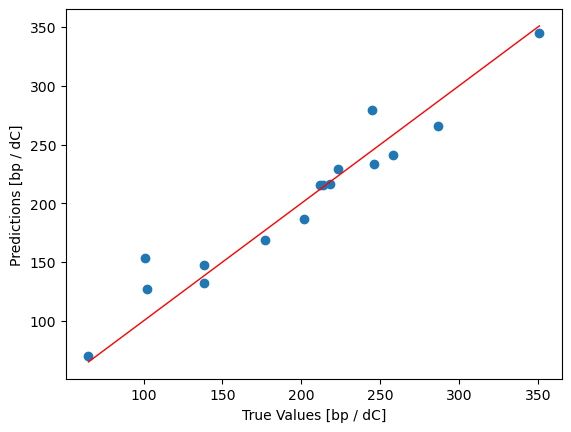

In [60]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '-', lw=1, color="red")
plt.xlabel("True Values [bp / dC]")
plt.ylabel("Predictions [bp / dC]")
plt.show()

In [63]:
# calculate the R^2 score
r2 = reg.score(scaled_X_test, y_test)
r2

0.9287935935680927

The model's predictions look the same as before, but we can now look at the coefficients.

In [64]:
print(X_full.columns)
reg.coef_

Index(['#O', 'Molweight g/mol', 'density / g/ml', 'NumHAcceptors',
       'NumHDonors', 'BalabanJ', 'BertzCT', 'TPSA'],
      dtype='object')


array([  1.65984399, 230.16481816,  81.1237445 , -10.77763669,
        37.44176379, -13.68670374,  12.45958115,  10.69260041])

We can now see that the coefficients which represent the weights of the features in the fitted model indicate that molecular weight - as expected - and density are contributing most strongly to the model